In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import data type 1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [95]:
# velocity = model, seismic = data
velocity_1 = np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/FlatVel_B/FlatVel_B_model_1.npy')
velocity_2 = np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/FlatVel_B/FlatVel_B_model_2.npy')
velocity_3 = np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/FlatVel_B/FlatVel_B_model_3.npy')

seismic_1 = np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/FlatVel_B/FlatVel_B_data_1.npy')
seismic_2 = np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/FlatVel_B/FlatVel_B_data_2.npy')
seismic_3 = np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/FlatVel_B/FlatVel_B_data_3.npy')



# Load custom colormap
rainbow_cmap = ListedColormap(np.load('/content/drive/MyDrive/Compressed_Sensing_Project/Data/OpenFWI/rainbow256.npy'))

In [96]:
print("Velocity shape:", velocity_1.shape)
print("Seismic shape:", seismic_1.shape)

v_min = velocity_1.min()
v_max = velocity_1.max()

print(f"Velocity range: {v_min:.2f}  –  {v_max:.2f}")


Velocity shape: (500, 1, 70, 70)
Seismic shape: (500, 5, 1000, 70)
Velocity range: 1501.00  –  4499.00


In [121]:
# Function for plot

def plot_velocity(output, target):
    fig, ax = plt.subplots(1, 3, figsize=(11, 5))
    fig.suptitle('Velocity Map Images', fontsize=20, y=0.9)

    # --- two velocity maps share one colour scale --------------------------
    vmin, vmax = target.min(), target.max()
    im_pred = ax[0].imshow(output, cmap=rainbow_cmap, vmin=vmin, vmax=vmax)
    im_true = ax[1].imshow(target, cmap=rainbow_cmap, vmin=vmin, vmax=vmax)

    # --- absolute difference needs its own, zero-based scale ---------------
    diff = np.abs(target - output)
    im_diff = ax[2].imshow(diff, cmap=rainbow_cmap, vmin=0, vmax=diff.max())

    # titles & axes ----------------------------------------------------------
    for a, title in zip(ax, ['Prediction', 'Ground Truth', 'Abs. Difference']):
        a.set_title(title, pad=10)
        a.set_xticks(range(0, 70, 10))
        a.set_xticklabels(range(0, 700, 100))
        a.set_yticks(range(0, 70, 10))
        a.set_yticklabels(range(0, 700, 100))
        a.set_xlabel('Offset (m)')
    ax[0].set_ylabel('Depth (m)')

    # --- separate colour-bars so scales don’t get mixed up -----------------
    cbar_vel  = fig.colorbar(im_true,  ax=ax[:2], shrink=0.75, label='Velocity (m/s)')
    cbar_diff = fig.colorbar(im_diff, ax=ax[2],  shrink=0.75, label='|ΔVelocity| (m/s)')

    #plt.tight_layout()
    plt.show()


def plot_seismic(sample, vmin=-1e-5, vmax=1e-5, cmap='gray'):
    """
    Display the 5 gathers in a single seismic sample.

    Parameters
    ----------
    sample : ndarray, shape (5, H, W)
        The selected seismic sample.
    vmin, vmax : float
        Amplitude limits for the display.
    cmap : str
        Matplotlib colormap (default 'gray').
    """
    if sample.ndim != 3 or sample.shape[0] != 5:
        raise ValueError('`sample` must have shape (5, H, W).')

    fig, axes = plt.subplots(1, 5, figsize=(20, 4), constrained_layout=True)
    fig.suptitle('Seismic Data Images', fontsize=20, y=1.2)

    for i, ax in enumerate(axes):
        im = ax.imshow(sample[i], aspect='auto', cmap=cmap,
                       vmin=vmin, vmax=vmax)
        ax.set_title(f'Location {i}', fontsize=14)
        ax.set_xticks(range(0, 70, 10))
        ax.set_xticklabels(range(0, 700, 100))
        ax.set_yticks(range(0, 2000, 1000))
        ax.set_yticklabels(range(0, 2,1))
        ax.set_ylabel('Time (s)', fontsize=12)
        ax.set_xlabel('Offset (m)', fontsize=12)

    fig.colorbar(im, ax=axes, shrink=0.8, label='Amplitude')
    plt.show()


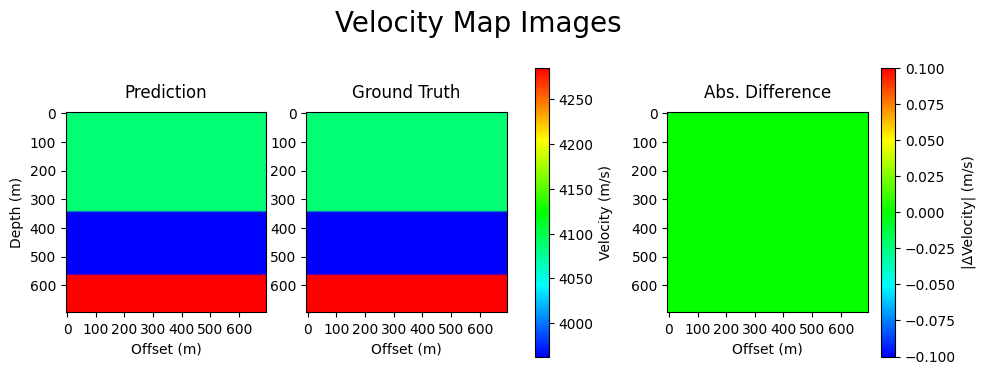

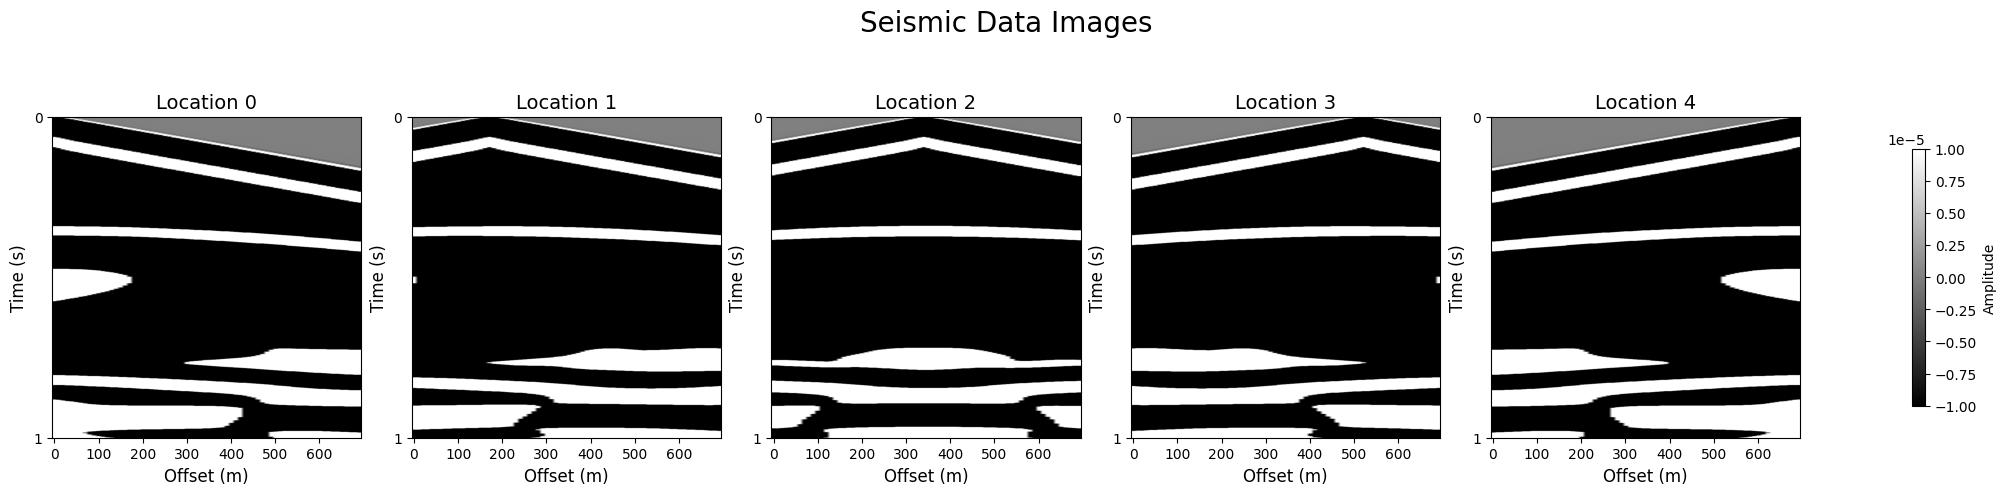

In [122]:
# Choose a sample
i = 0  # index of the sample
j = 2  # which source of the 5

# Show velocity map
plot_velocity(velocity_1[i, 0], velocity_1[i, 0])  # prediction vs ground truth (same for now)

# Show seismic shot record
plot_seismic(seismic_1[i])  # prediction vs ground truth (same for now)

In [98]:
# prepare data for train/test split
velocities = np.concatenate([velocity_1, velocity_2, velocity_3], axis=0)
seismics = np.concatenate([seismic_1, seismic_2, seismic_3], axis=0)

print("Velocity shape:", velocities.shape)
print("Seismic shape:", seismics.shape)

Velocity shape: (1500, 1, 70, 70)
Seismic shape: (1500, 5, 1000, 70)


In [65]:
# ──────────────────────────────────────────────────────────────
#  A FLEXIBLE DETERMINISTIC SPLITTER
# ──────────────────────────────────────────────────────────────
def split_pairs(velocities, seismics,
                n_train, n_test=None):
    """
    velocities : (N_total, 1, 70, 70)
    seismics   : (N_total, 5, 1000, 70)
    n_train    : # samples to keep for training
    n_test     : # samples to keep for testing
                 • if None  -> take *all the rest* after n_train
                 • if -1    -> same as None for convenience
    returns (train_v, test_v, train_s, test_s)
    """
    N_total = velocities.shape[0]
    if n_test is None or n_test == -1:
        n_test = N_total - n_train

    assert n_train + n_test <= N_total, \
        f"Requested {n_train+n_test} > total {N_total}"

    train_v = velocities[:n_train]
    test_v  = velocities[n_train : n_train + n_test]

    train_s = seismics[:n_train]
    test_s  = seismics[n_train  : n_train + n_test]

    return train_v, test_v, train_s, test_s


In [119]:
N_TRAIN = 400
N_TEST  = 100

# split once
train_v, test_v, train_s, test_s = split_pairs(
        velocities, seismics,
        n_train=N_TRAIN, n_test=N_TEST
)

# derive hyper-parameters at the *same* proportions
K      = int(round(0.64 * N_TRAIN))          # 256 when 400
T0     = max(5, int(round(0.06 * K)))        # 15   when 256
d_pca  = int(round(0.5 * N_TRAIN))          # 300  when 400
n_iter = 15

print(f"train={N_TRAIN}, test={N_TEST}  →  K={K}, T0={T0}, d_pca={d_pca}")


train=400, test=100  →  K=256, T0=15, d_pca=200


1st Method for CS ( k-svd )




In [7]:
from numpy.linalg import svd, lstsq

In [79]:

# ------------------------------------------------------------------
# 1.  flatten / unflatten helpers ──────────────────────────────────
# ------------------------------------------------------------------
def flatten_velocity(batch):                      # (B,1,70,70) ➔ (4900, B)
    return batch.reshape(batch.shape[0], -1).T

def unflatten_velocity(mat):                      # (4900,B) ➔ (B,1,70,70)
    return mat.T.reshape(mat.shape[1], 1, 70, 70)

def flatten_seismic(batch):                       # (B,5,1000,70) ➔ (350000, B)
    return batch.reshape(batch.shape[0], -1).T.astype(np.float32)

# ------------------------------------------------------------------
# 2.  PCA compression for huge seismic vectors  (method-of-snapshots)
# ------------------------------------------------------------------
'''
def pca_train(Y, d):
    """
    Y : (M, N)  zero-mean seismic matrix  (M=350 000, N=400)
    d :         #principal components to keep  (e.g. 300)
    returns components (M,d) and eigenvalue sqrt(S)
    """
    C = Y.T @ Y                                  # (N,N)  400×400
    S2, V = np.linalg.eigh(C)                    # small eigendecomp
    idx = np.argsort(S2)[::-1][:d]               # top-d
    S = np.sqrt(S2[idx])
    V = V[:, idx]
    components = (Y @ V) / S                     # (M,d)
    return components.astype(np.float32), S
'''
def pca_train(Y, d, verbose=True):
    """
    Y : (M, N)   zero-mean seismic matrix  (M = 350 000, N = 400)
    d : int      # principal components to keep
    verbose :    if True, prints explained-variance ratio

    returns
        components : (M, d)
        S          : sqrt(eigenvalues)  length d
    """
    C = Y.T @ Y                      # (N,N)  = 400×400 covariance
    eigvals, V = np.linalg.eigh(C)   # ascending order
    idx_sorted = np.argsort(eigvals)[::-1]        # largest → first
    eigvals = eigvals[idx_sorted]                 # reorder
    V = V[:, idx_sorted]

    total_var = eigvals.sum()
    kept_var  = eigvals[:d].sum()
    if verbose:
        ratio = kept_var / total_var
        print(f"[PCA] keeping {d} / 400 comps  →  "
              f"explained variance = {ratio:.4%}")

    S = np.sqrt(eigvals[:d])         # length-d singular values
    components = (Y @ V[:, :d]) / S  # (M, d)
    return components.astype(np.float32), S

def pca_project(Y, components, mean):
    """
    Projects seismic vectors to d-dim PCA space
    Y         : (M, B) raw flattened seismic
    components: (M, d)
    mean      : (M, 1)
    returns   : (d, B)
    """
    return components.T @ (Y - mean)

# ------------------------------------------------------------------
# 3.  Orthogonal Matching Pursuit
# ------------------------------------------------------------------
def omp(D, y, T0):
    K = D.shape[1]
    residual = y.copy()
    idxs = []
    x = np.zeros(K)

    for _ in range(T0):
        j = np.argmax(np.abs(D.T @ residual))
        if j in idxs: break
        idxs.append(j)
        x_sub, *_ = lstsq(D[:, idxs], y, rcond=None)
        residual = y - D[:, idxs] @ x_sub
        if np.linalg.norm(residual) < 1e-6: break
    x[idxs] = x_sub
    return x

# ------------------------------------------------------------------
# 4.  Coupled K-SVD  (velocity+seismic-PCA stacked) ────────────────
# ------------------------------------------------------------------
def ksvd(Y_joint, K, T0, n_iter):
    m, N = Y_joint.shape
    rng = np.random.default_rng(0)
    D = Y_joint[:, rng.choice(N, K, replace=False)]     # init
    D /= np.linalg.norm(D, axis=0, keepdims=True)

    for it in range(n_iter):
        X = np.zeros((K, N))
        for n in range(N):
            X[:, n] = omp(D, Y_joint[:, n], T0)

        for k in range(K):
            om = np.nonzero(X[k, :])[0]
            if om.size == 0: continue
            R = Y_joint[:, om] - D @ X[:, om] + np.outer(D[:, k], X[k, om])
            U, S, Vt = svd(R, full_matrices=False)
            D[:, k] = U[:, 0]
            X[k, om] = S[0] * Vt[0, :]
        D /= np.linalg.norm(D, axis=0, keepdims=True)

        print(f"[{it+1}/{n_iter}]  avg residual = {np.linalg.norm(Y_joint-D@X)/N:.4f}")

        rel_err = np.linalg.norm(Y_joint - D @ X) / np.linalg.norm(Y_joint)
        print(f"[{it+1}] rel RMS error = {rel_err:.3%}")


    return D, X

# ------------------------------------------------------------------
# 5.  Training wrapper  ────────────────────────────────────────────
# ------------------------------------------------------------------
def train_coupled_dictionary(train_vel, train_seis, K=100, T0=10, n_iter=10, d_pca=300):
    # ---- normalise velocity
    mu_v = train_vel.mean();  sigma_v = train_vel.std()
    V = ((train_vel - mu_v) / sigma_v).astype(np.float32)
    Vf = flatten_velocity(V)                                  # (4900,N)

    # ---- seismic PCA
    Sf_raw = flatten_seismic(train_seis)                      # (350k,N)
    mu_s = Sf_raw.mean(axis=1, keepdims=True)
    comps, _ = pca_train(Sf_raw - mu_s, d_pca)                # (350k,d)
    Sf = pca_project(Sf_raw, comps, mu_s)                     # (d,N)

    # ---- stack and run K-SVD
    Y = np.vstack([Vf, Sf])                                   # (4900+d, N)
    D, X = ksvd(Y, K, T0, n_iter)

    # partition dictionary
    Dv = D[:4900, :]
    Ds = D[4900:, :]

    return {
        "Dv": Dv, "Ds": Ds, "X_train": X,
        "mu_v": mu_v, "sigma_v": sigma_v,
        "mu_s": mu_s, "comps": comps,
        "K": K, "T0": T0
    }

# ------------------------------------------------------------------
# 6.  Reconstruction on *new seismic* ──────────────────────────────
# ------------------------------------------------------------------
def reconstruct_velocity(test_seis,
                         model,
                         test_vel=None     # <- ground truth
                        ):
    """
    test_seis : (N_test, 5, 1000, 70)
    model     : dict  from train_coupled_dictionary
    test_vel  : (N_test, 1, 70, 70)   ground-truth (optional)

    returns
        V_hat : reconstructed velocity maps, shape = test_vel
        X     : sparse codes  (K, N_test)
        metrics : dict with 'MSE', 'MAE'  (None if test_vel not supplied)
    """
    Ds   = model["Ds"];      Dv = model["Dv"]
    mu_s = model["mu_s"];    comps = model["comps"]
    mu_v = model["mu_v"];    sigma_v = model["sigma_v"]
    T0   = model["T0"]

    # -------- 1. PCA projection of seismic block
    Sf_raw = flatten_seismic(test_seis)           # (350k, N)
    Sf     = pca_project(Sf_raw, comps, mu_s)     # (d, N)

    # -------- 2. sparse codes via OMP on seismic dictionary
    K, N = Ds.shape[1], Sf.shape[1]
    X = np.zeros((K, N), dtype=np.float32)
    for n in range(N):
        X[:, n] = omp(Ds, Sf[:, n], T0)

    # -------- 3. reconstruct velocity slice and de-normalise
    V_norm = Dv @ X                               # (4900, N)
    V_hat  = unflatten_velocity(V_norm)           # (N,1,70,70)
    V_hat  = V_hat * sigma_v + mu_v               # back to m/s

    # -------- 4. metrics (if ground truth available)
    metrics = None
    if test_vel is not None:
        mse = np.mean((V_hat - test_vel)**2)
        mae = np.mean(np.abs(V_hat - test_vel))
        metrics = {"MSE": float(mse), "MAE": float(mae)}
        print(f"[TEST]  MSE = {mse:.2f}  |  MAE = {mae:.2f}  (m/s)")

    return V_hat.astype(np.float32), X, metrics

In [120]:
# tranining
# ---- 1. learn coupled dictionary on the 400 training pairs ----
model = train_coupled_dictionary(train_v, train_s,
                                 K=K,     # atoms per modality
                                 T0=T0,     # sparsity
                                 n_iter=n_iter, # outer K-SVD loops
                                 d_pca=d_pca) # seismic PCA dim



[PCA] keeping 200 / 400 comps  →  explained variance = 99.9958%
[1/15]  avg residual = 2.4384
[1] rel RMS error = 7.845%
[2/15]  avg residual = 2.0135
[2] rel RMS error = 6.478%
[3/15]  avg residual = 1.8964
[3] rel RMS error = 6.101%
[4/15]  avg residual = 1.8141
[4] rel RMS error = 5.836%
[5/15]  avg residual = 1.7593
[5] rel RMS error = 5.660%
[6/15]  avg residual = 1.7286
[6] rel RMS error = 5.561%
[7/15]  avg residual = 1.7066
[7] rel RMS error = 5.491%
[8/15]  avg residual = 1.6824
[8] rel RMS error = 5.413%
[9/15]  avg residual = 1.6650
[9] rel RMS error = 5.357%
[10/15]  avg residual = 1.6454
[10] rel RMS error = 5.294%
[11/15]  avg residual = 1.6280
[11] rel RMS error = 5.238%
[12/15]  avg residual = 1.6243
[12] rel RMS error = 5.226%
[13/15]  avg residual = 1.6066
[13] rel RMS error = 5.169%
[14/15]  avg residual = 1.6054
[14] rel RMS error = 5.165%
[15/15]  avg residual = 1.5871
[15] rel RMS error = 5.106%


In [123]:
# ---- 2. reconstruct velocity maps for 100 *unseen* seismic cubes ----
V_rec, codes, metrics_N400 = reconstruct_velocity(
        test_seis=test_s,
        model=model,
        test_vel=test_v          # supply GT to get metrics
)
print("Reconstruction shape:", V_rec.shape)       # (100, 1, 70, 70)

[TEST]  MSE = 940672.06  |  MAE = 702.70  (m/s)
Reconstruction shape: (100, 1, 70, 70)


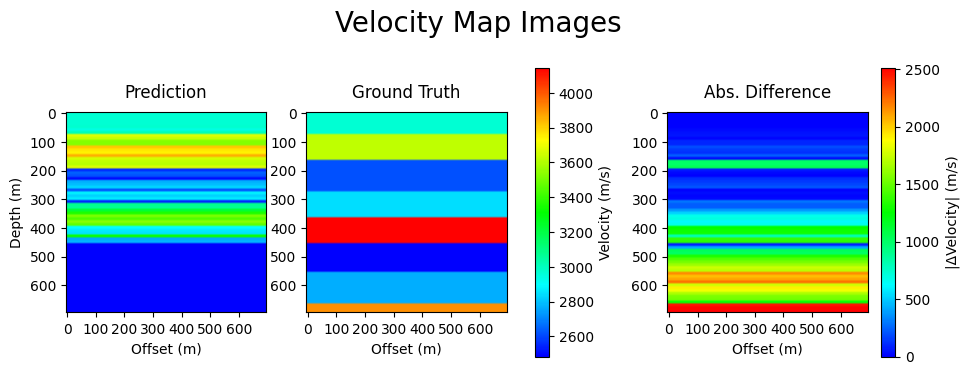

In [124]:
plot_velocity(V_rec[0, 0], test_v[0, 0])  # prediction vs ground truth (same for now)

In [118]:
# FlatVel_A
print(metrics_N400)
print(metrics_N800)
print(metrics_N1200)

# FlatVel_B
print(metrics_N400)
print(metrics_N800)
print(metrics_N1200)

{'MSE': 940672.0625, 'MAE': 702.70166015625}
{'MSE': 910241.0625, 'MAE': 674.5122680664062}
{'MSE': 717325.0625, 'MAE': 579.873291015625}
{'MSE': 940672.0625, 'MAE': 702.70166015625}
{'MSE': 910241.0625, 'MAE': 674.5122680664062}
{'MSE': 717325.0625, 'MAE': 579.873291015625}


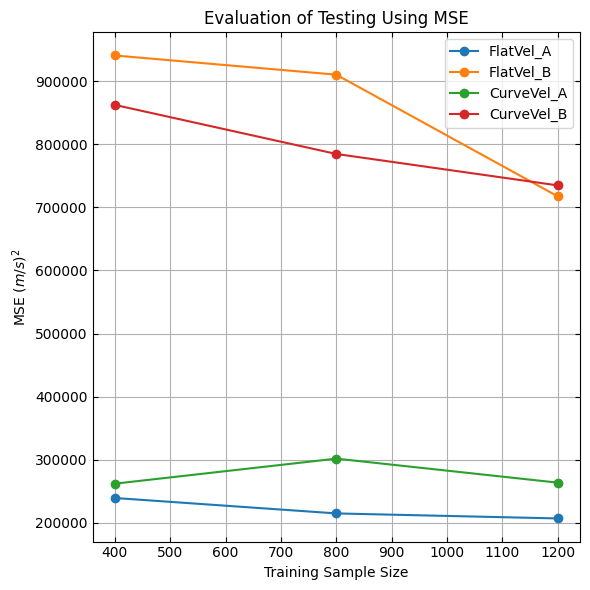

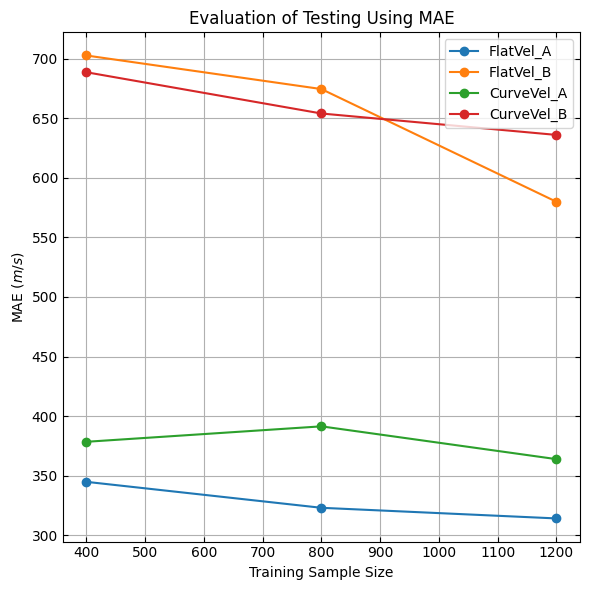

In [135]:


# Training sample sizes
x = [400, 800, 1200]

# MSE values for each type
mse_flatvel_a = [239408.19, 214957.86, 207009.94]
mse_flatvel_b = [940672.06, 910241.06, 717325.06]
mse_curvevel_a = [262092.31, 301769.47, 263694.93]
mse_curvevel_b = [862377.13, 784597.69, 734765.88]

# MAE values for each type
mae_flatvel_a = [344.83, 323.03, 314.10]
mae_flatvel_b = [702.7, 674.51, 579.87]
mae_curvevel_a = [378.43, 391.40, 363.86]
mae_curvevel_b = [688.64, 654.00, 636.01]


fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, mse_flatvel_a, label='FlatVel_A', marker='o')
ax.plot(x, mse_flatvel_b, label='FlatVel_B', marker='o')
ax.plot(x, mse_curvevel_a, label='CurveVel_A', marker='o')
ax.plot(x, mse_curvevel_b, label='CurveVel_B', marker='o')
ax.set_title('Evaluation of Testing Using MSE')
ax.set_xlabel('Training Sample Size')
ax.set_ylabel('MSE $(m/s)^2$')
ax.legend(loc='upper right', frameon=True)
ax.grid(True)
ax.tick_params(axis='both', direction='in', top=True, right=True)
for spine in ax.spines.values():
    spine.set_visible(True)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, mae_flatvel_a, label='FlatVel_A', marker='o')
ax.plot(x, mae_flatvel_b, label='FlatVel_B', marker='o')
ax.plot(x, mae_curvevel_a, label='CurveVel_A', marker='o')
ax.plot(x, mae_curvevel_b, label='CurveVel_B', marker='o')
ax.set_title('Evaluation of Testing Using MAE')
ax.set_xlabel('Training Sample Size')
ax.set_ylabel('MAE $(m/s)$')
ax.legend(loc='upper right', frameon=True)
ax.grid(True)
ax.tick_params(axis='both', direction='in', top=True, right=True)
for spine in ax.spines.values():
    spine.set_visible(True)
plt.tight_layout()
plt.show()


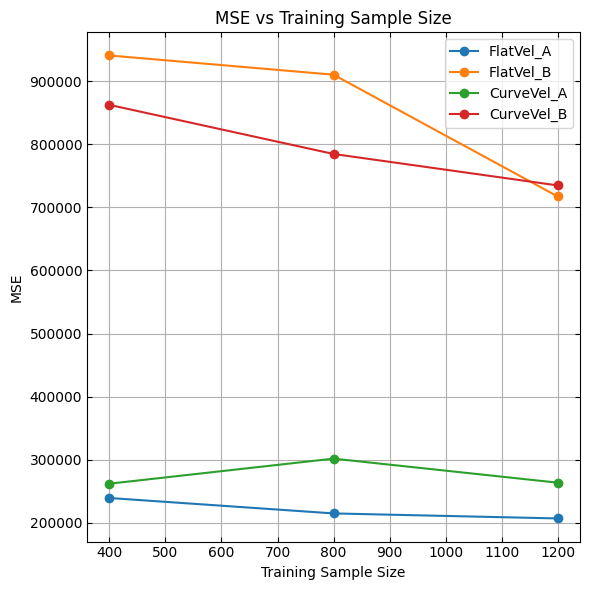

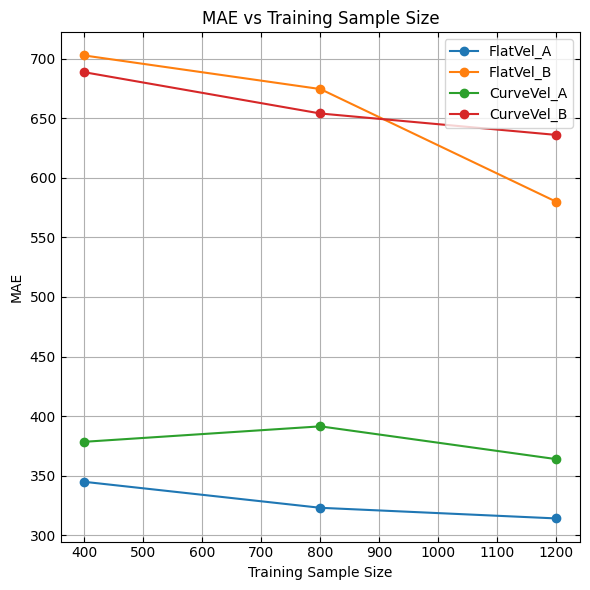

In [130]:

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, mse_flatvel_a, label='FlatVel_A', marker='o')
ax.plot(x, mse_flatvel_b, label='FlatVel_B', marker='o')
ax.plot(x, mse_curvevel_a, label='CurveVel_A', marker='o')
ax.plot(x, mse_curvevel_b, label='CurveVel_B', marker='o')
ax.set_title('MSE vs Training Sample Size')
ax.set_xlabel('Training Sample Size')
ax.set_ylabel('MSE')
ax.legend()
ax.grid(True)

# Add ticks and spines on all four sides
ax.tick_params(axis='both', direction='in', top=True, right=True)
for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(x, mae_flatvel_a, label='FlatVel_A', marker='o')
ax.plot(x, mae_flatvel_b, label='FlatVel_B', marker='o')
ax.plot(x, mae_curvevel_a, label='CurveVel_A', marker='o')
ax.plot(x, mae_curvevel_b, label='CurveVel_B', marker='o')
ax.set_title('MAE vs Training Sample Size')
ax.set_xlabel('Training Sample Size')
ax.set_ylabel('MAE')
ax.legend()
ax.grid(True)

# Add ticks and spines on all four sides
ax.tick_params(axis='both', direction='in', top=True, right=True)
for spine in ax.spines.values():
    spine.set_visible(True)

plt.tight_layout()
plt.show()
